In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import lettuce as lt
from lettuce import D3Q19, Lattice, UnitConversion, BGKCollision, StandardStreaming, Simulation, IncompressibleKineticEnergy, WallQuantities, SimulationHWBB
from argparse import ArgumentParser, ArgumentDefaultsHelpFormatter
import csv

In [2]:
from argparse import ArgumentParser, ArgumentDefaultsHelpFormatter
import numpy as np
import torch

parser = ArgumentParser(formatter_class=ArgumentDefaultsHelpFormatter)
parser.add_argument("--vtkdir", type=str, default="./output/")
parser.add_argument("--csvdir", type=str, default="./output/")
parser.add_argument("--nout", type=int, default=100)
parser.add_argument("--nvtk", type=int, default=100)
parser.add_argument("--tmax", type=int, default=5)
parser.add_argument("--Re", type=int, default=13800)
parser.add_argument("--collision_operator", type=str, default="Smag")
parser.add_argument("--Precision", type=str, default="Single")
parser.add_argument("--Mach", type=float, default=0.1)
parser.add_argument("--h", type=int, default=20, help="Halbe Kanalhöhe in LU")
parser.add_argument("--bbtype", type=str, default="wallfunction", choices=["halfway", "fullway", "wallfunction", "freeslip"],
                    help="Typ der Bounce-Back-Randbedingung")

args, unknown = parser.parse_known_args()
args = vars(args)

print("ICH FUNKTIONIERE MIT PULLEN")



# Einheiten und Auflösung
h = args["h"]                      # Kanalhalbhöhe in LU
res_y = 2 * h                     # y: volle Kanalhöhe
res_x = int(2*np.pi * h)
res_z = int(np.pi * h)

# Restliche Parameter
Re = args["Re"]
basedir = args["vtkdir"]
csvdir = args["csvdir"]
nout = args["nout"]
nvtk = args["nvtk"]
tmax = args["tmax"]
Precision = args["Precision"]
collision_operator = args["collision_operator"]
Mach = args["Mach"]
bbtype = args["bbtype"]
# Präzision
if Precision == "Single":
    dtype = torch.float32
elif Precision == "Double":
    dtype = torch.float64
elif Precision == "Half":
    dtype = torch.float16


Re_tau = 180



ICH FUNKTIONIERE MIT PULLEN


In [3]:
# Überprüfen, ob CUDA verfügbar ist
if torch.cuda.is_available():
    device = "cuda"
    print("CUDA ist verfügbar. Verwende GPU.")
else:
    device = "cpu"
    print("CUDA ist nicht verfügbar. Verwende CPU.")

# Dann kannst du das Lattice entsprechend initialisieren
lattice = Lattice(D3Q19, device=device, dtype=dtype)

flow = lt.ChannelFlow3D(
    resolution_x=res_x,
    resolution_y=res_y,
    resolution_z =res_z,
    reynolds_number=Re,
    mach_number=Mach,
    lattice=lattice,
    char_length_lu=res_y,
    boundary = bbtype
)

# --- 🧱 Wände definieren ---
x, y, z = flow.grid  # physikalische Gitterkoordinaten

# y in LU umrechnen (nur nötig, falls du nach physikalischen Einheiten schneiden willst)
# Hier reicht aber die Indexierung direkt, da wir die äußersten Zeilen meinen:
mask = np.zeros((res_x, res_y, res_z), dtype=bool)
mask[:, 0, :] = True         # untere Wand (y = 0)
mask[:, -1, :] = True        # obere Wand (y = max)
flow.mask = mask

nu = flow.units.viscosity_lu

u_tau = Re_tau * nu / h

# Kraft
F_x = u_tau**2 / h
print(F_x)
# Guo-Force definieren
acceleration = [F_x,0,0]# --- 🌀 Forcing (Guo) ---

# --- 🌀 Forcing (Guo) ---
from lettuce.force import Guo  # dein Guo-Code
forcing = Guo(lattice, tau=flow.units.relaxation_parameter_lu, acceleration=acceleration)

# --- 🔁 Setup Simulation ---
if collision_operator == "BGK":
    collision=lt.BGKCollision(lattice, tau=flow.units.relaxation_parameter_lu, force=forcing)
elif collision_operator == "KBC":
    collision=lt.KBCCollision3D(lattice, tau=flow.units.relaxation_parameter_lu, force = forcing)
elif collision_operator == "Smag":
    collision=lt.SmagorinskyCollision(lattice, tau=flow.units.relaxation_parameter_lu, force = forcing)

if args["bbtype"] == "halfway":
    from lettuce.boundary import HalfwayBounceBackBoundary
    boundary = HalfwayBounceBackBoundary(mask, lattice)
    simulation_class = SimulationHWBB
    dy_lu = 0.5  # Mitte zwischen Wand und 1. Zellzentrum
else:
    simulation_class = Simulation  # normale Basisklasse
    dy_lu = 1.0  # Abstand zwischen Wandzentrum und Zellzentrum




streaming = StandardStreaming(lattice)
simulation = simulation_class(flow=flow, lattice=lattice, collision=collision, streaming=streaming)

# --- 📊 Beobachter ---
Energy = IncompressibleKineticEnergy(lattice, flow)
reporter = lt.ObservableReporter(Energy, interval=100, out=None)
simulation.reporters.append(reporter)

wq = WallQuantities(lattice,flow,averaging_steps = 1)
reporter2 = lt.ObservableReporter(wq, interval=100, out=None)
simulation.reporters.append(reporter2)

simulation.initialize_f_neq

# --- ▶️ Simulation starten ---
steps = int(flow.units.convert_time_to_lu(tmax))  # z.B. 5 Sekunden
vtk_reporter = lt.VTKReporter(
    lattice=lattice,
    flow=flow,
    interval=int(steps/100),                    # alle 100 Zeitschritte ein VTK-Frame
    filename_base=basedir + "/output" # Basisname der Dateien
)
simulation.reporters.append(vtk_reporter)
mlups = simulation.step(num_steps=steps)

wq = np.array(simulation.reporters[1].out)
Energy = np.array(simulation.reporters[0].out)

with open(csvdir + 'Energy.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(Energy)
with open(csvdir + 'WallQuantities.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(wq)

CUDA ist verfügbar. Verwende GPU.
1.1342155009451797e-07
steps     time     IncompressibleKineticEnergy
steps     time     WallQuantities
[WallQuantities] Avg Re_tau_bottom: 76.02, y+_bottom: 3.80
[WallQuantities] Avg Re_tau_top:    75.61, y+_top:    3.78
[WallQuantities] Avg Re_tau_bottom: 65.44, y+_bottom: 3.27
[WallQuantities] Avg Re_tau_top:    64.34, y+_top:    3.22
[WallQuantities] Avg Re_tau_bottom: 74.64, y+_bottom: 3.73
[WallQuantities] Avg Re_tau_top:    73.12, y+_top:    3.66
[WallQuantities] Avg Re_tau_bottom: 65.59, y+_bottom: 3.28
[WallQuantities] Avg Re_tau_top:    64.98, y+_top:    3.25
[WallQuantities] Avg Re_tau_bottom: 65.66, y+_bottom: 3.28
[WallQuantities] Avg Re_tau_top:    61.21, y+_top:    3.06
[WallQuantities] Avg Re_tau_bottom: 73.58, y+_bottom: 3.68
[WallQuantities] Avg Re_tau_top:    65.61, y+_top:    3.28
[WallQuantities] Avg Re_tau_bottom: 72.34, y+_bottom: 3.62
[WallQuantities] Avg Re_tau_top:    62.75, y+_top:    3.14
[WallQuantities] Avg Re_tau_bottom: 

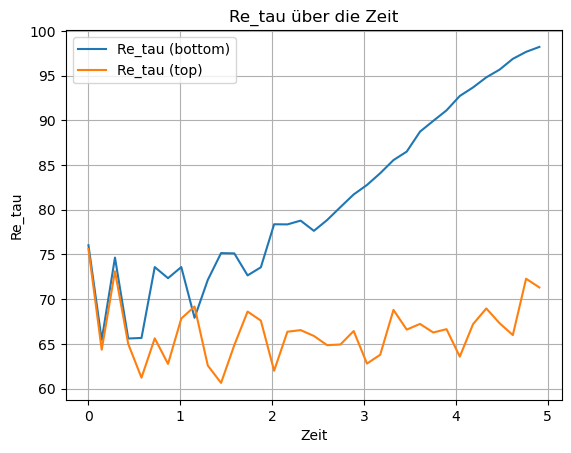

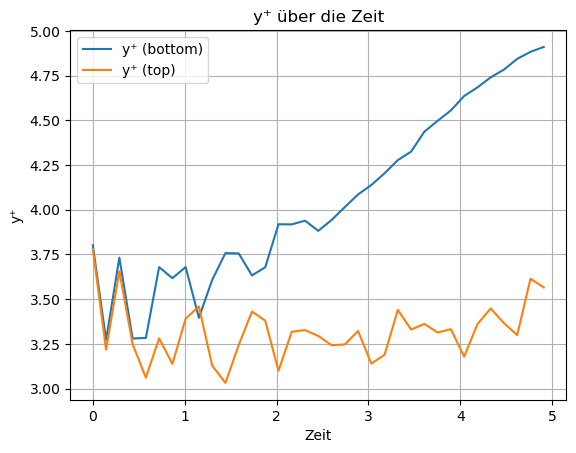

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Beispiel: Daten laden
data = wq
time = data[:, 1]
re_tau_bottom = data[:, 2]
y_plus_bottom = data[:, 3]
re_tau_top = data[:, 4]
y_plus_top = data[:, 5]

plt.figure()
plt.plot(time, re_tau_bottom, label="Re_tau (bottom)")
plt.plot(time, re_tau_top, label="Re_tau (top)")
plt.xlabel("Zeit")
plt.ylabel("Re_tau")
plt.legend()
plt.grid()
plt.title("Re_tau über die Zeit")
plt.show()

plt.figure()
plt.plot(time, y_plus_bottom, label="y⁺ (bottom)")
plt.plot(time, y_plus_top, label="y⁺ (top)")
plt.xlabel("Zeit")
plt.ylabel("y⁺")
plt.legend()
plt.grid()
plt.title("y⁺ über die Zeit")
plt.show()
